# Final Project

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np 

# Optimisation
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import scipy.optimize as opt
from sklearn.covariance import EmpiricalCovariance
from sklearn.linear_model import LinearRegression
import statistics

# Model Packages
import pypfopt as pyp
import riskfolio as rp

# Section 1 - Data Exploration and Analysis

**1.1 Pre-Processing**
-

**Load df**

In [2]:
# Load dataset
df = pd.read_csv(r'gp_data_1986_to_2015.csv', index_col= 'Month')

print(df.columns.to_list(), df.shape)

# Show df head
df.head(5)

['Mkt-RF', 'RF', 'Agric', 'Food ', 'Soda ', 'Beer ', 'Smoke', 'Toys ', 'Fun  ', 'Books', 'Hshld', 'Clths', 'Hlth ', 'MedEq', 'Drugs', 'Chems', 'Rubbr', 'Txtls', 'BldMt', 'Cnstr', 'Steel', 'FabPr', 'Mach ', 'ElcEq', 'Autos', 'Aero ', 'Ships', 'Guns ', 'Gold ', 'Mines', 'Coal ', 'Oil  ', 'Util ', 'Telcm', 'PerSv', 'BusSv', 'Comps', 'Chips', 'LabEq', 'Paper', 'Boxes', 'Trans', 'Whlsl', 'Rtail', 'Meals'] (360, 45)


,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
Month,,,,,,,,,,,,,,,,,,,,,
198601,0.65,0.56,7.92,2.38,-1.20,-0.86,5.55,2.14,3.91,-0.78,...,0.78,-1.11,0.85,3.80,4.61,1.91,5.60,2.48,1.67,-0.09
198602,7.13,0.53,13.98,7.89,11.68,7.71,12.20,10.72,8.28,14.67,...,7.47,2.71,8.34,9.98,8.68,10.61,7.03,8.85,7.21,9.27
198603,4.88,0.60,2.74,7.84,10.89,9.17,11.52,5.65,6.86,5.07,...,4.96,-0.11,0.04,-1.15,4.18,5.61,3.22,7.41,9.11,6.42
198604,-1.31,0.52,5.24,-0.57,4.44,-2.92,3.64,3.91,8.36,-1.14,...,3.33,3.87,3.55,2.69,-2.50,-0.93,-2.64,1.70,-0.70,3.86
198605,4.62,0.49,1.08,8.55,7.95,6.37,10.16,3.16,5.91,10.96,...,5.41,1.01,-0.75,2.51,6.66,5.07,0.70,5.52,11.95,4.89


**Excess returns**

In [3]:
# Obtain excess returns
ex_rets = df.iloc[:,-43:].copy()
ex_rets = ex_rets.apply(lambda x: (x - df['RF']))
ex_rets.columns = ex_rets.columns.str.replace(' ', '')

# Show excess returns head
ex_rets.head(5)

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
Month,,,,,,,,,,,,,,,,,,,,,
198601,7.36,1.82,-1.76,-1.42,4.99,1.58,3.35,-1.34,-1.52,4.66,...,0.22,-1.67,0.29,3.24,4.05,1.35,5.04,1.92,1.11,-0.65
198602,13.45,7.36,11.15,7.18,11.67,10.19,7.75,14.14,10.20,8.80,...,6.94,2.18,7.81,9.45,8.15,10.08,6.50,8.32,6.68,8.74
198603,2.14,7.24,10.29,8.57,10.92,5.05,6.26,4.47,4.97,5.57,...,4.36,-0.71,-0.56,-1.75,3.58,5.01,2.62,6.81,8.51,5.82
198604,4.72,-1.09,3.92,-3.44,3.12,3.39,7.84,-1.66,-2.18,-3.30,...,2.81,3.35,3.03,2.17,-3.02,-1.45,-3.16,1.18,-1.22,3.34
198605,0.59,8.06,7.46,5.88,9.67,2.67,5.42,10.47,4.12,9.29,...,4.92,0.52,-1.24,2.02,6.17,4.58,0.21,5.03,11.46,4.40


**1.2 Basic Portfolio Construction and In-Sample Analysis**
-

**Helper functions - Obtaining weights**

In [4]:
def mu_V (df):

    ##########
    # Derive [0] estimate of expected return vector (MU) & [1] estimate of covariance matrix (V)
    #
    # Input: df (Historical Return Data)
    # Outputs: Vhat, mu_hat
    ##########

    return [EmpiricalCovariance().fit(df).location_, EmpiricalCovariance().fit(df).covariance_]

def portfolio_weights(input_list, port_type):

    ##########
    # Construct portfolios using closed form methods.  
    #
    # Input: Follow the df inputs required by each type of portfolio below
    #   (1) 'tan': [mu, V]  expected ret vector and covariance matrix
    #   (2) 'gmv': [V]      covariance matrix
    #   (3) 'ewp': [n]      number of assets
    # Output: Converted df
    ##########

    if port_type == 'tan':
        mu, V = input_list[0], input_list[1]
        w_t = np.linalg.inv(V) @ mu
        w_t /= np.sum(w_t)
        return w_t

    elif port_type == 'gmv':
        V = input_list[0]
        n = len(V)
        w_g = np.linalg.inv(V) @ np.ones(n)
        w_g /= np.sum(w_g)
        return w_g

    elif port_type == 'ewp':
        n = len(input_list[0].columns)
        return np.ones(n)/n

**Obtaining weights**

In [5]:
def obtain_standard_weights(ex_rets):

    # Obtain inputs for Portfolio Weights function
    weight_inputs, basic_port = [[ex_rets], mu_V(ex_rets), [mu_V(ex_rets)[1]]], ['ewp', 'tan', 'gmv']

    # Create lists of weights using function
    ew_w, tan_w, gmv_w = [portfolio_weights(weight_inputs[i], basic_port[i]) for i in range(len(basic_port))]

    # Zip lists together
    weights_df = pd.DataFrame(zip(ew_w, tan_w, gmv_w), 
                                columns = [str(i.upper())+ ' Weights' for i in basic_port],
                                index = ex_rets.columns.to_list())

    # Check sum 
    # for column in weights_df.columns:
    #     print('Sum for ' +str(column) + ' = ' + str(weights_df[column].sum().round(0)))
    
    return weights_df

# Show weights_df head
weights_df = obtain_standard_weights(ex_rets)
weights_df.head(5)

,EWP Weights,TAN Weights,GMV Weights
Agric,0.023256,-0.050933,0.080757
Food,0.023256,0.158097,0.099587
Soda,0.023256,0.057595,-0.004510
Beer,0.023256,0.143384,-0.011566
Smoke,0.023256,0.259716,-0.041839


**Helper functions - Obtaining metrics**

In [6]:
def portfolio_metrics(w, data_evaluate):
    
    ###########
    # Evaluate the performance of a portfolio (i.e., weight vector) given the return data to evaluate on
    # Input: data contains historical return information (every column corresponds to an asset)
    #        w is the portfolio weight vector
    #        (NB: risk-free rate has already been assumed to be zero)
    # Output: The performance metrics of the portfolio 
    #         (i.e., expected return, standard deviation, variance, and Sharpe ratio)
    ###########
    # print(type(w), w.shape)
    # Sanity check for the input format
    w = np.array(w)
    # w = w.reshape((-1))
    if (data_evaluate.shape[1] != len(w)):
        print('Warning: data and w should contain the same number of assets')
    ### End of sanity check
    # print('check here')
    # print(type(w), w.shape)
    mu, V = mu_V(data_evaluate)

    return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w), 
        'var': w.T @ V @ w, 'Sharpe': (mu.T @ w - 0)/(np.sqrt(w.T @ V @ w)) }

**Obtaining metrics**

In [7]:
def obtain_standard_mets(weights_df, ex_rets):
    # Create containers
    metrics_df, met_inds = pd.DataFrame(), []

    # Create df iteratively
    for i in weights_df.columns:
        metrics_df = pd.concat([metrics_df,pd.DataFrame.from_dict(portfolio_metrics(weights_df[i].to_list(), ex_rets), orient = 'index')], axis = 1)
        met_inds.append(i[:3])
        
    metrics_df = metrics_df.set_axis(met_inds, axis = 1)

    return metrics_df

metrics_df = obtain_standard_mets(obtain_standard_weights(ex_rets), ex_rets) # LEFT IS TRAIN< RIGHT IS TEST
metrics_df.head(5)

,EWP,TAN,GMV
Er,0.718348,1.916838,0.562142
sigma,4.650387,5.281517,2.860151
var,21.626103,27.894421,8.180464
Sharpe,0.154470,0.362933,0.196543


In [8]:
def obtain_mkt_values(metrics_df, df):
    # Get market values
    mkt_er, mkt_std, mkt_var, mkt_sharpe = df['Mkt-RF'].mean(), df['Mkt-RF'].std(), df['Mkt-RF'].var(), df['Mkt-RF'].mean()/df['Mkt-RF'].std()
    metrics_df['MKT'] = [mkt_er, mkt_std, mkt_var, mkt_sharpe]

    return metrics_df
# Show metrics_df head
metrics_df = obtain_mkt_values(obtain_standard_mets(obtain_standard_weights(ex_rets), ex_rets), df)
metrics_df.round(5)

,EWP,TAN,GMV,MKT
Er,0.71835,1.91684,0.56214,0.63636
sigma,4.65039,5.28152,2.86015,4.48453
var,21.62610,27.89442,8.18046,20.11098
Sharpe,0.15447,0.36293,0.19654,0.14190


**Helper functions: Graphs for in-sample analysis**

In [9]:
def get_EF_on_data (w_t, w_g, data_evaluate):

    ###########
    # Get the (evaluated) efficient frontier curve using the two-fund separation method
    #
    # Input: data contains historical return information to evaluate on (every column corresponds to an asset)
    #        w_t and w_g are the constructed tangency and global minimum variance portfolios, respectively
    #        (NB: if w_t and w_g are obtained from the training data but "data" is actually testing data,
    #         then the output EF could be highly sub-optimal!)
    # Output: The risk-return combinations of portfolios on the (evaluated) EF 
    ###########
    
    trange = np.arange(0,2,0.01)
    sigma_range = np.zeros_like (trange) * np.nan
    Er_range = np.zeros_like (trange) * np.nan

    for i in np.arange(len(trange)):
        w_mix = trange[i] * w_t + (1-trange[i]) * w_g
        sigma_range[i] = portfolio_metrics(w_mix, data_evaluate) ['sigma']
        Er_range[i] = portfolio_metrics(w_mix, data_evaluate) ['Er']
        
    return sigma_range, Er_range

**Efficient frontier**

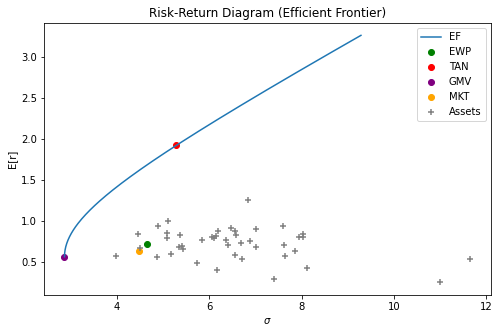

In [10]:
def plot_ef(data_train):

    ###########
    # A Summary function
    #
    # Input: The portfolios are all obtrained from "data_train"; 
    #        Their performances are all evaluated on "data_train" as well
    # Output: A plot that contrains tangency portfolio, GMV, EF, and equally weighted portfolio
    ###########
    plt.figure(figsize = (8,5))
    
    # Obtain the tangency, GMV, equally weighted portfolios from the TRAINING data
    mu_train, V_train = mu_V(data_train)

    # Obtain inputs for Portfolio Weights function, create weights list
    weight_inputs, basic_port = [[data_train], mu_V(data_train), [mu_V(data_train)[1]]], ['ewp', 'tan', 'gmv']
    w_list = w_e, w_t_train, w_g_train = [portfolio_weights(weight_inputs[i], basic_port[i]) for i in range(len(basic_port))]

    # Obtain efficient frontier using Two-fund separation method
    sigma_range, Er_range = get_EF_on_data (w_t_train, w_g_train, data_train)
    plt.plot(sigma_range, Er_range, label = 'EF')
    
    # Pyplot function
    markers, color, labels = ['o' for i in range(3)], ['g', 'r', 'purple'], ['EWP', 'TAN', 'GMV']

    # Plot portfolios
    for i in range(len(w_list)):
        plt.scatter(portfolio_metrics(w_list[i], data_train)['sigma'], 
                    portfolio_metrics(w_list[i], data_train)['Er'], 
                    marker= markers[i], 
                    c = color[i] ,
                    label = labels[i])

    # Plot market portfolio
    plt.scatter(metrics_df.at['sigma', 'MKT'] , 
                metrics_df.at['Er', 'MKT'] , marker='o', color = 'orange',label = 'MKT')

    # Plot assets
    er_list, vol_list = [], []
    for i in data_train.columns:
        er_list.append(data_train[i].mean())
        vol_list.append(data_train[i].std())
    
    plt.scatter(vol_list, er_list, marker='+', c = 'gray' ,label = 'Assets')

    plt.legend()
    plt.title('Risk-Return Diagram (Efficient Frontier)')
    plt.xlabel('$\sigma$')
    plt.ylabel('E[r]')
    
    plt.show()

# EF: Volatility vs Er 
plot_ef(ex_rets)

**Security Market Line**

In [11]:
# Find Covariance matrix and mkt variance
v = pd.concat([df['Mkt-RF'], ex_rets], axis=1).cov()
mkt_var = v.at['Mkt-RF', 'Mkt-RF']

# Find list of betas
cov_beta = [(i/mkt_var).round(5) for i in v['Mkt-RF'].values.tolist()]
stock_betas = cov_beta[1:]
print(stock_betas)

# Create df with weights
betas_df, port_betas, cols = weights_df.copy(), [], []
betas_df['Betas'] = stock_betas

for i in betas_df.columns[:3]:
    port_betas.append((betas_df['Betas']*betas_df[i]).sum())
    cols.append(i)
port_betas.append(1)
metrics_df.loc[len(metrics_df)] = port_betas
metrics_df = metrics_df.rename(index = {4: 'Beta'})

[0.78129, 0.5999, 0.82538, 0.6393, 0.63292, 1.04433, 1.34429, 1.03052, 0.7166, 1.08233, 0.83713, 0.85419, 0.74591, 1.05416, 1.0544, 1.1929, 1.1376, 1.19558, 1.43734, 1.07187, 1.26566, 1.24125, 1.26283, 1.01211, 1.071, 0.58204, 0.40539, 1.09886, 1.10959, 0.72354, 0.4151, 0.9288, 0.96819, 1.27172, 1.35527, 1.4565, 1.27583, 0.92657, 0.97796, 0.9344, 0.91521, 0.96756, 0.83838]


In [12]:
metrics_df

,EWP,TAN,GMV,MKT
Er,0.718348,1.916838,0.562142,0.636361
sigma,4.650387,5.281517,2.860151,4.484527
var,21.626103,27.894421,8.180464,20.110982
Sharpe,0.154470,0.362933,0.196543,0.141902
Beta,0.983295,0.526041,0.400153,1.000000


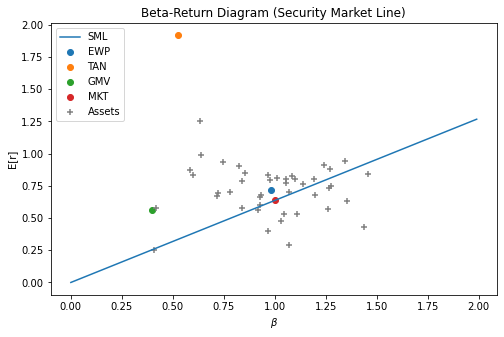

In [13]:
# SML: Beta vs Er

def plot_sml(data_train):
    
    plt.figure(figsize = (8,5))

    # Plot SML (CAPM definition)
    rm, bs = df['Mkt-RF'].mean(), np.arange(0, 2, 0.01)
    assetReturns = [rm*x for x in bs] # RF rate is 0
    plt.plot(bs, assetReturns, label = 'SML')

    # Plot betas for portfolios
    for i in range(len(metrics_df.columns)):
        plt.scatter(metrics_df.iat[4, i],
                    metrics_df.iat[0, i],
                    label = metrics_df.columns[i]
                    )

    # Plot betas for assets
    er_list = []
    for i in data_train.columns:
        er_list.append(data_train[i].mean())  
    plt.scatter(stock_betas, er_list, marker='+', c = 'gray' ,label = 'Assets')

    # Plot params
    plt.legend()
    plt.title('Beta-Return Diagram (Security Market Line)')
    plt.xlabel(r'$\beta$')
    plt.ylabel('E[r]')

    plt.show()

plot_sml(ex_rets)

**1.3 Robust Porfolio Construction and Out-of-sample Analysis**
-

**Train-test split**

In [14]:
# Train_Test_Split
ex_rets_train = ex_rets.loc[:'201012', :]
ex_rets_test = ex_rets.loc['201101':, :]

# Mkt-RF Split
df1= df.loc[:'201012'] # Use with train
df2 = df.loc['201101':] # USe with test

In [15]:
ex_rets_train.head(5)

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
Month,,,,,,,,,,,,,,,,,,,,,
198601,7.36,1.82,-1.76,-1.42,4.99,1.58,3.35,-1.34,-1.52,4.66,...,0.22,-1.67,0.29,3.24,4.05,1.35,5.04,1.92,1.11,-0.65
198602,13.45,7.36,11.15,7.18,11.67,10.19,7.75,14.14,10.20,8.80,...,6.94,2.18,7.81,9.45,8.15,10.08,6.50,8.32,6.68,8.74
198603,2.14,7.24,10.29,8.57,10.92,5.05,6.26,4.47,4.97,5.57,...,4.36,-0.71,-0.56,-1.75,3.58,5.01,2.62,6.81,8.51,5.82
198604,4.72,-1.09,3.92,-3.44,3.12,3.39,7.84,-1.66,-2.18,-3.30,...,2.81,3.35,3.03,2.17,-3.02,-1.45,-3.16,1.18,-1.22,3.34
198605,0.59,8.06,7.46,5.88,9.67,2.67,5.42,10.47,4.12,9.29,...,4.92,0.52,-1.24,2.02,6.17,4.58,0.21,5.03,11.46,4.40


In [16]:
# Create beta function
def create_betas(df, ex_rets):
    v = pd.concat([df['Mkt-RF'], ex_rets], axis=1).cov()
    mkt_var = v.at['Mkt-RF', 'Mkt-RF']

    # Find list of betas
    cov_beta = [(i/mkt_var).round(5) for i in v['Mkt-RF'].values.tolist()]
    stock_betas = cov_beta[1:]

    return pd.DataFrame(zip(ex_rets.columns.tolist(), stock_betas), columns = ['Industry', 'Beta'])

# Get betas for train and test
train_betas = create_betas(df1, ex_rets_train)

train_betas.head(5)

,Industry,Beta
0,Agric,0.73990
1,Food,0.59697
2,Soda,0.86344
3,Beer,0.66278
4,Smoke,0.62689


**Estimating Beta**

In [17]:
# Obtain Grand Avg Beta

def estimate_beta(betas_df):
    grand_avg_beta = betas_df.Beta.mean()
    # print('Grand Avg Beta: ' + str(grand_avg_beta.round(3)))

    # Shrunken betas xd
    betas_df['Robust Beta'] = betas_df.Beta.apply(lambda x: 0.5*grand_avg_beta + 0.5 * x)

    return betas_df

train_betas = estimate_beta(train_betas)

train_betas.head(5)

,Industry,Beta,Robust Beta
0,Agric,0.73990,0.857013
1,Food,0.59697,0.785548
2,Soda,0.86344,0.918783
3,Beer,0.66278,0.818453
4,Smoke,0.62689,0.800508


**Estimating Expected Return**

In [18]:
# Get mu CAPM
def estimate_return(df, betas_df):
    rm = df['Mkt-RF'].mean()
    betas_df['Mu CAPM'] = betas_df['Robust Beta']*rm
    betas_df.head(5)
    return betas_df

train_estimates = estimate_return(df1, train_betas)

train_estimates.head(5)

,Industry,Beta,Robust Beta,Mu CAPM
0,Agric,0.73990,0.857013,0.481185
1,Food,0.59697,0.785548,0.441059
2,Soda,0.86344,0.918783,0.515866
3,Beer,0.66278,0.818453,0.459534
4,Smoke,0.62689,0.800508,0.449459


**Estimating Correl Matrix**

In [19]:
# Function to return constant correl
def estimate_const_corr(ex_rets):

    # Obtain covariance matrix (43x300)
    sample_cov_matrix = ex_rets.cov()
    sample_cov_matrix = sample_cov_matrix.values


    # Obtain sigma (43x1)
    var = np.diag(sample_cov_matrix).reshape(-1, 1)
    std = np.sqrt(var)

    # Obtain rho bar
    n = len(ex_rets.columns)
    _std = np.tile(std, (n,))
    r_bar = (np.sum(sample_cov_matrix / (_std * _std.T)) - n) / (n * (n - 1))

    # Obtain constant correl
    vcc = r_bar * (_std * _std.T)
    vcc[np.eye(n) == 1] = var.reshape(-1)

    return vcc

def estimate_vshrink(ex_rets, shrek):

    # Obtain covariance matrix
    sample_cov_matrix = ex_rets.cov()
    sample_cov_matrix = sample_cov_matrix.values  

    # Obtain constant correl matrix
    const_corr_matrix = estimate_const_corr(ex_rets)

    return pd.DataFrame(shrek*const_corr_matrix + (1-shrek)*sample_cov_matrix)

vshrink_train   = estimate_vshrink(ex_rets_train, 0.3)

vshrink_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,42.451075,12.777359,17.209770,14.250394,16.219475,18.914251,22.638322,18.296609,13.223025,20.850108,...,20.903907,21.584443,23.892899,22.037766,16.420213,18.782065,17.231559,16.281772,17.546442,16.058984
1,12.777359,21.779965,17.443900,15.594761,18.491971,16.165161,17.568479,14.612466,13.324245,17.727510,...,13.496575,12.765217,13.542835,14.209125,13.929295,14.572044,13.161099,13.146036,14.960421,14.271160
2,17.209770,17.443900,55.908805,22.182191,20.202499,23.873275,29.542519,22.979945,19.239053,25.678783,...,21.233660,22.694546,25.323608,24.002609,21.703203,21.708653,20.390975,20.700827,20.286513,20.347367
3,14.250394,15.594761,22.182191,29.627435,17.614668,18.133782,19.659889,14.860450,16.521366,18.113976,...,15.614236,15.218682,16.755136,16.111384,16.074474,16.009318,15.115613,13.786886,16.046628,16.005152
4,16.219475,18.491971,20.202499,17.614668,52.002929,19.335637,21.328569,16.091168,15.338208,19.056979,...,16.705665,17.801113,17.488624,18.884657,17.748387,18.127234,14.123070,17.852719,14.949859,15.885271


**Obtain weights for robust portfolios**

In [20]:
def robust_weights(ex_rets, vshrink, estimates):

    # Obtain inputs for Portfolio Weights function
    weight_inputs, basic_port = [[estimates['Mu CAPM'], vshrink],[vshrink]], ['tan', 'gmv']

    # Create lists of weights using function
    tan_rob, gmv_rob = [portfolio_weights(weight_inputs[i], basic_port[i]) for i in range(len(basic_port))]

    # Zip lists together
    weights_df = pd.DataFrame(zip(tan_rob, gmv_rob), 
                                columns = [str(i.upper())+ '-Robust Weights' for i in basic_port],
                                index = ex_rets.columns.to_list())

    # Check sum 
    # for column in weights_df.columns:
    #     print('Sum for ' +str(column) + ' = ' + str(weights_df[column].sum().round(0)))
    
    return weights_df

train_weights = robust_weights(ex_rets_train, vshrink_train, train_estimates)
train_weights.head(5)

,TAN-Robust Weights,GMV-Robust Weights
Agric,0.011692,0.042940
Food,0.078334,0.103069
Soda,-0.032075,-0.027098
Beer,-0.002360,0.000207
Smoke,-0.056370,-0.055792


**Obtain evaluation metrics for robust portfolios on the train set**

In [21]:
def robust_metrics(ex_rets, weights_df): #, estimates, vshrink):
    # Create containers
    metrics_df, met_inds = pd.DataFrame(), []

    # Create df iteratively
    for i in weights_df.columns:
        metrics_df = pd.concat([metrics_df,pd.DataFrame.from_dict(portfolio_metrics(weights_df[i].to_list(), ex_rets), orient = 'index')], axis = 1)
        met_inds.append(i[:10])

    return metrics_df.set_axis(met_inds, axis = 1)

In [22]:
# In sample analysis - construct from train and evaluate on train
train_robust_metrics = robust_metrics(ex_rets_train, train_weights) #, train_estimates, vshrink_train)
train_metrics = obtain_mkt_values(obtain_standard_mets(obtain_standard_weights(ex_rets_train), ex_rets_train), df1)
in_sample_metrics = pd.concat([train_metrics, train_robust_metrics], axis = 1)  
in_sample_metrics

,EWP,TAN,GMV,MKT,TAN-Robust,GMV-Robust
Er,0.697483,2.100185,0.467903,0.561467,0.539940,0.486128
sigma,4.792854,6.103180,2.880749,4.657505,3.406655,3.050177
var,22.971451,37.248808,8.298714,21.692354,11.605295,9.303578
Sharpe,0.145526,0.344113,0.162424,0.120551,0.158496,0.159377


In [23]:
# Out sample analysis - construct from train and evaluate on test
test_robust_metrics = robust_metrics(ex_rets_test, train_weights) #, train_estimates, vshrink_train)
test_metrics = obtain_mkt_values(obtain_standard_mets(obtain_standard_weights(ex_rets_train), ex_rets_test), df2)
out_sample_metrics = pd.concat([test_metrics, test_robust_metrics], axis = 1)  
out_sample_metrics

,EWP,TAN,GMV,MKT,TAN-Robust,GMV-Robust
Er,0.822671,1.055857,0.863082,1.010833,1.141517,1.122783
sigma,3.858277,4.201550,2.963800,3.502378,2.712158,2.708489
var,14.886303,17.653022,8.784112,12.266648,7.355800,7.335914
Sharpe,0.213222,0.251302,0.291208,0.288613,0.420889,0.414542


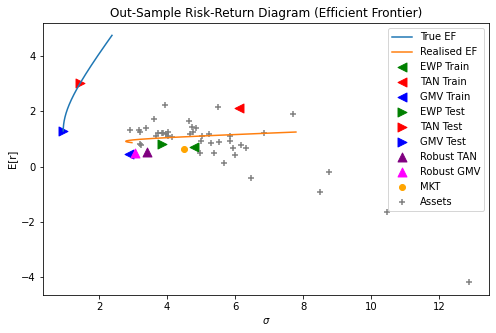

In [24]:
def plot_ef2(mrp, data_train, data_test):

    ###########
    # A Summary function
    #
    # Input: The portfolios are all obtrained from "data_train"; 
    #        Their performances are evaluated on "data_test" OR "data_train"
    # Output: A plot that contrains tangency portfolio, GMV, EF, and equally weighted portfolio
    ###########
    plt.figure(figsize = (8,5))
    
    # Obtain the tangency, GMV, equally weighted portfolios from the TRAINING data
    mu_train, V_train = mu_V(data_train)
    vshrink_train, train_estimates = estimate_vshrink(data_train, 0.3), estimate_return(mrp, estimate_beta(create_betas(mrp, data_train)))
    
    # Obtain inputs for Portfolio Weights function
    weight_inputs_rob, basic_port_rob = [[train_estimates['Mu CAPM'], vshrink_train],[vshrink_train]], ['tan', 'gmv']
    w_list_rob = tan_rob, gmv_rob = [portfolio_weights(weight_inputs_rob[i], basic_port_rob[i]) for i in range(len(basic_port_rob))]
    
    # Obtain inputs for Portfolio Weights function, create weights list - TEST
    weight_inputs_test, basic_port_test = [[data_test], mu_V(data_test), [mu_V(data_test)[1]]], ['ewp', 'tan', 'gmv']
    w_list_test = w_e, w_t_test, w_g_test = [portfolio_weights(weight_inputs_test[i], basic_port_test[i]) for i in range(len(basic_port_test))]

    # Obtain inputs for Portfolio Weights function, create weights list - TRAIN
    weight_inputs, basic_port = [[data_train], mu_V(data_train), [mu_V(data_train)[1]]], ['ewp', 'tan', 'gmv']
    w_list = w_e, w_t_train, w_g_train = [portfolio_weights(weight_inputs[i], basic_port[i]) for i in range(len(basic_port))]

    # Obtain True-EF using Two-fund separation method
    sigma_true_range, Er_true_range = get_EF_on_data(w_t_test, w_g_test, data_test)
    plt.plot(sigma_true_range, Er_true_range, label = 'True EF')
    
    # Obtain Realised-EF using Two-fund separation method
    sigma_r_range, Er_r_range = get_EF_on_data(w_t_train, w_g_train, data_test)
    plt.plot(sigma_r_range, Er_r_range, label = 'Realised EF')
    
    # Pyplot function
    markers, color, labels, s = ['<' for i in range(3)], ['g', 'r', 'b'], ['EWP Train', 'TAN Train', 'GMV Train'], [80,80,80]
    markers3, color3, labels3, s3 = ['>' for i in range(3)], ['g', 'r', 'b'], ['EWP Test', 'TAN Test', 'GMV Test'], [80,80,80]
    markers2, color2, labels2, s2 = ['^' for i in range(2)], ['purple', 'magenta'], ['Robust TAN', 'Robust GMV'], [80,80,80]

    # Plot portfolios
    for i in range(len(w_list)):
        plt.scatter(portfolio_metrics(w_list[i], data_train)['sigma'], 
                    portfolio_metrics(w_list[i], data_train)['Er'], 
                    marker= markers[i], 
                    c = color[i] ,
                    label = labels[i],
                    s = s[i])
        
    for i in range(len(w_list_test)):
        plt.scatter(portfolio_metrics(w_list_test[i], data_test)['sigma'], 
                    portfolio_metrics(w_list_test[i], data_test)['Er'], 
                    marker= markers3[i], 
                    c = color3[i] ,
                    label = labels3[i],
                    s = s3[i])
        
        
    for i in range(len(w_list_rob)):
        plt.scatter(portfolio_metrics(w_list_rob[i], data_train)['sigma'], 
                    portfolio_metrics(w_list_rob[i], data_train)['Er'], 
                    marker= markers2[i], 
                    c = color2[i] ,
                    label = labels2[i],
                    s = s2[i])

    # Plot market portfolio
    plt.scatter(metrics_df.at['sigma', 'MKT'] , 
                metrics_df.at['Er', 'MKT'] , marker='o', color = 'orange',label = 'MKT')

    # Plot assets
    er_list, vol_list = [], []
    for i in data_test.columns:
        er_list.append(data_test[i].mean())
        vol_list.append(data_test[i].std())
    
    plt.scatter(vol_list, er_list, marker='+', c = 'gray' ,label = 'Assets')

    plt.legend()
    plt.title('Out-Sample Risk-Return Diagram (Efficient Frontier)')
    plt.xlabel('$\sigma$')
    plt.ylabel('E[r]')
    
    plt.show()

# EF: Volatility vs Er 
plot_ef2(df1, ex_rets_train, ex_rets_test)

# Data Challenge

**Preparing data for backtesting**

In [25]:
ex_rets_with_mkt = ex_rets.copy()
ex_rets_with_mkt['Mkt-RF'] = df['Mkt-RF']
ex_rets_with_mkt.head(5)

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals,Mkt-RF
Month,,,,,,,,,,,,,,,,,,,,,
198601,7.36,1.82,-1.76,-1.42,4.99,1.58,3.35,-1.34,-1.52,4.66,...,-1.67,0.29,3.24,4.05,1.35,5.04,1.92,1.11,-0.65,0.65
198602,13.45,7.36,11.15,7.18,11.67,10.19,7.75,14.14,10.20,8.80,...,2.18,7.81,9.45,8.15,10.08,6.50,8.32,6.68,8.74,7.13
198603,2.14,7.24,10.29,8.57,10.92,5.05,6.26,4.47,4.97,5.57,...,-0.71,-0.56,-1.75,3.58,5.01,2.62,6.81,8.51,5.82,4.88
198604,4.72,-1.09,3.92,-3.44,3.12,3.39,7.84,-1.66,-2.18,-3.30,...,3.35,3.03,2.17,-3.02,-1.45,-3.16,1.18,-1.22,3.34,-1.31
198605,0.59,8.06,7.46,5.88,9.67,2.67,5.42,10.47,4.12,9.29,...,0.52,-1.24,2.02,6.17,4.58,0.21,5.03,11.46,4.40,4.62


Text(0.5, 1.0, 'Dendrogram of 43 Industries (DBHT linkage)')

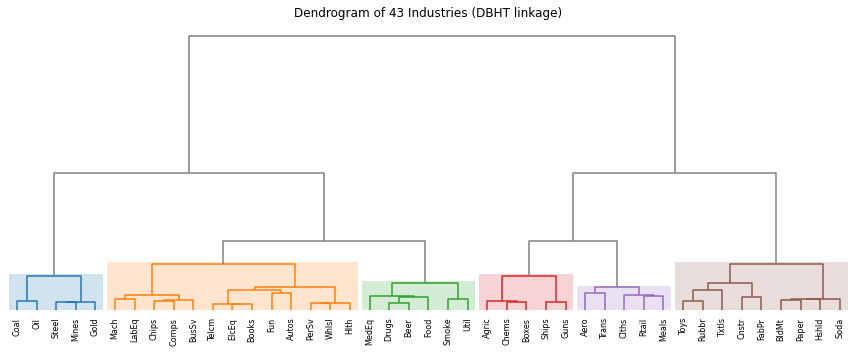

In [26]:
# Dendrogram - Clustering of Industries using the DBHT linkage 
rp.plot_dendrogram(returns = ex_rets,
                   linkage = 'DBHT',   # DBHT Linkage offers most sensible results with best clustering
                   max_k = 10)
plt.title('Dendrogram of 43 Industries (DBHT linkage)')

**Hierachical Risk-Parity Portfolio**

In [27]:
from pypfopt import HRPOpt

In [28]:
hrp = HRPOpt(ex_rets_train)
hrp_weights = hrp.optimize()

hrp_df = pd.DataFrame.from_dict(dict(hrp_weights), orient = 'index', columns = ['HRP Weight'])
hrp_df.head(5)

,HRP Weight
Aero,0.014868
Agric,0.049453
Autos,0.016773
Beer,0.040890
BldMt,0.012055


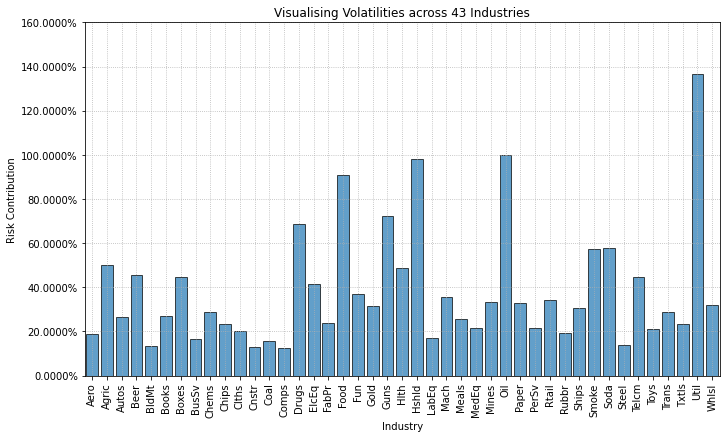

In [29]:
# Bar Chart - Volatilities across 43 Industries
rp.plot_risk_con(w = hrp_df,
                 cov = ex_rets_train.cov(),
                 returns = ex_rets_train,
                 rm = 'MV',
                 rf = 0.04,
                 alpha = 0.05,
                 t_factor = 12)

plt.title('Visualising Volatilities across 43 Industries')
plt.ylabel('Risk Contribution')
plt.xlabel('Industry')
plt.show()

In [30]:
def evaluate_rpp(ex_rets_train, ex_rets_test):

    # Using HRPOpt
    hrp = HRPOpt(ex_rets_train)
    hrp_weights = hrp.optimize()

    weights_df = pd.DataFrame.from_dict(dict(hrp_weights), orient = 'index', columns = ['HRP Weight'])

    # Create containers
    metrics_df, met_inds = pd.DataFrame(), []

    # Create df iteratively
    for i in weights_df.columns:
        metrics_df = pd.concat([metrics_df,pd.DataFrame.from_dict(portfolio_metrics(weights_df[i].to_list(), ex_rets_test), orient = 'index')], axis = 1)
        met_inds.append(i[:3])

    return metrics_df.set_axis(met_inds, axis = 1)    

**Tangency with optimised shrinkage estimators**

In [31]:
from pypfopt import risk_models

In [32]:
def evaluate_leodoit_tan(train, test_assets, assets):

    ###############
    # Input:    - Train and test sets (With mkt)
    # Output:   Port metrics against test set
    ###############

    train_assets, weight_dict = train[assets], {}
    # Type = 'constant_variance', 'single_factor', 'constant_correlation'
    for type in ['constant_variance', 'single_factor', 'constant_correlation']:
        # Returns shrunk covariance matrix
        vshrink = (risk_models.CovarianceShrinkage(train_assets, returns_data= True, frequency=12)
                            .ledoit_wolf(shrinkage_target= type))

        # Returns capm defined expected returns for tangency
        mucapm = estimate_return(train, estimate_beta(create_betas(train, train_assets)))

        # Obtain inputs for Portfolio Weights function
        weight_inputs, basic_port = [[mucapm['Mu CAPM'], vshrink]], ['tan']

        # Create lists of weights using function
        tan_rob= [portfolio_weights(weight_inputs[i], basic_port[i]) for i in range(len(basic_port))]

        # Store in dict
        type = 'Tan-' + str(type)
        weight_dict[type] = list(tan_rob[0])


    # # Zip lists together
    weights_df = pd.DataFrame.from_dict(weight_dict,orient='index').transpose()

        # Create containers
    metrics_df= pd.DataFrame()

    # Create df iteratively
    for i in weights_df.columns:
        metrics_df = pd.concat([metrics_df,pd.DataFrame.from_dict(portfolio_metrics(weights_df[i].to_list(), test_assets), orient = 'index')], axis = 1)
    
    metrics_df.set_axis(['TAN (Leodoit) - Constant Var','TAN (Leodoit) - Single Factor', 'TAN (Leodoit) - Constant Correl'], axis = 1, inplace = True)
    
    return metrics_df

**Black Litterman Portfolio**

In [33]:
# Idzorek's Black Litterman Methodology
# Inputs: Covariance Matrix, Implied Market Returns (Monthly), Views, Confidence  

## Covariance Matrix 
def obtain_bl_cov_matrix(ex_rets, test_assets, bullorbear):

    cov_matrix = ex_rets.cov()  

    ## Implied Market Returns 
    w_asset = ex_rets.sum()/(ex_rets.sum().sum()) 
    global_rets = (w_asset.values*ex_rets.mean()).sum()
    mkt_var = np.matmul(w_asset.values.reshape(len(w_asset)).T,
                        np.matmul(cov_matrix.values, w_asset.values.reshape(len(w_asset))))
    risk_tol = global_rets / mkt_var

    def implied_mkt_rets(risk_tol, sigma, w):
        implied_mkt_rets = risk_tol * sigma.dot(w).squeeze() 
        return implied_mkt_rets

    implied_mkt_rets = implied_mkt_rets(risk_tol, cov_matrix, w_asset) 

    ## Views 
    view = pd.DataFrame({'Industries':ex_rets.columns,
                        'View':[0]*43, 'Confidence of View':[0]*43})

    ### Energy: Petroleum & Natural Gas, Utilities, and Coal 
    energy = [x.strip() for x in 'Util, Oil, Coal'.split(',')]
    ### Materials: Chemicals, Construction Materials, Shipping Containers, Precious Metals, Non-Metallic and Industrial Metal Mining (Mines), Steel Works etc., Rubber & Plastic, Paper, and Fabricated Products. 
    materials = [x.strip() for x in 'Chems, BldMt, Boxes, Gold, Steel, Mines, Rubbr, Paper, FabPr'.split(',')]
    ### Industrials: Construction, Aircraft, Defense, Shipbuilding & Railroad Equipment, Electrical Equipment, Automobiles & Trucks, Machinery, and Transportation.
    industrials = [x.strip() for x in 'Cnstr, Aero, Guns, Ships, ElcEq, Autos, Mach, Trans'.split(',')]
    ### Health Care: Healthcare, Medical Equipment, Laboratory Equipment, and Pharmaceutical Products.
    healthcare = [x.strip() for x in 'Hlth, MedEq, LabEq, Drugs'.split(',')]
    ### Consumer Staples: Agriculture, Food Products, Tobacco Products, Candy & Soda, Beer & Liquor, and Wholesale. 
    con_staples = [x.strip() for x in 'Agric, Food, Smoke, Soda, Beer, Whlsl'.split(',')]
    ### Consumer Discretionary: Textiles, Entertainment, Recreation, Apparel, Restaurants, Hotels, Motels (Meals), Retail, Business Services, Consumer Goods and Personal Services.
    con_disc = [x.strip() for x in 'Txtls, Fun, Toys, Clths, Meals, Rtail, BusSv, Hshld, PerSv'.split(',')]
    ### Technology: Electronic Equipment, Computers, Printing & Publishing, and Communications.
    tech_comms = [x.strip() for x in 'Chips, Comps, Books, Telcm'.split(',')]

    # Multiplier ==================================================================================================
    # Check values
    multiplier = 1
    if bullorbear == 'bull':
        multiplier = 1.10
    elif bullorbear == 'bear':
        multiplier = 0.75
    elif bullorbear == 'neutral':
        multiplier = 1
    # =============================================================================================================

    # Views and confidences
    industries = [energy, materials, industrials, healthcare, con_staples, con_disc, tech_comms]
    views = [5/12, 5/12, 3/12, 10/12, 5/12, 2/12, 15/12 ]
    confidence = [0.30, 0.30,0.30, 0.65, 0.30, 0.30, 0.65]
    for i in range(len(industries)):
        view.loc[view['Industries'].isin(industries[i]),'View'] = views[i]* multiplier
        view.loc[view['Industries'].isin(industries[i]),'Confidence of View'] = confidence[i] * multiplier

    view = view.set_index('Industries')

    views = {ind : view['View'][ind] for ind in view.index}
    confidences = [view['Confidence of View']]

    # Black Litterman Model 
    blp =  pyp.BlackLittermanModel(cov_matrix, pi = implied_mkt_rets, absolute_views = views, omega = "idzorek", view_confidences = confidences) 

    # Output: Comparison of Returns by Industry
    blp_rets_comps = pd.DataFrame([implied_mkt_rets, ex_rets.mean(), pd.Series(views), blp.bl_returns()], 
                                index=['Imp. Return','Hist. Return','View','BL Return']).T

    blp_rets_comps = blp_rets_comps.reset_index(level=0)
    blp_rets_comps.columns = ['Industry','Imp. Return','Hist. Return','View','BL Return']
    blp_rets_comps['Sector'] = ['0']*43

    formal_titles = ['Energy', 'Materials', 'Industrials', 'Health Care', 'Consumer Staples', 'Consumer Discretionary', 'Tech & Comms']

    for i in range(len(industries)):
        blp_rets_comps.loc[blp_rets_comps['Industry'].isin(industries[i]),'Sector'] = formal_titles[i]

    blp_rets_comps = blp_rets_comps[['Sector','Industry','Imp. Return','Hist. Return','View','BL Return']]
    blp_rets_comps = blp_rets_comps.set_index('Sector')

    # Output: Comparison of Weights by Industry
    w_blp = blp.bl_weights()
    comp_w_blp = pd.DataFrame(list(zip([i for i in w_blp],
                [i for i in blp.bl_weights().values()],
                [i for i in w_asset])),
                columns=['Industry','BL Weight','Market Cap. Weight'])

    comp_w_blp['Sector'] = ['0']*43

    for i in range(len(industries)):
        comp_w_blp.loc[comp_w_blp['Industry'].isin(industries[i]),'Sector'] = formal_titles[i]

    comp_w_blp = comp_w_blp[['Sector','Industry','BL Weight','Market Cap. Weight']]
    comp_w_blp = comp_w_blp.set_index('Sector')

    # Cambrie, I changed here onwards to obtain le metrics - tat
    comp_w_blp = comp_w_blp.iloc[:, 1:]

    # Create containers
    metrics_df = pd.DataFrame()

    # # Create df iteratively
    for i in comp_w_blp.columns:
        metrics_df = pd.concat([metrics_df,pd.DataFrame.from_dict(portfolio_metrics(comp_w_blp[i].to_list(), test_assets), orient = 'index')], axis = 1)
    
    metrics_df.set_axis(['BL', 'BL Market Cap'], axis = 1, inplace = True)    

    return metrics_df

**Backtesting**

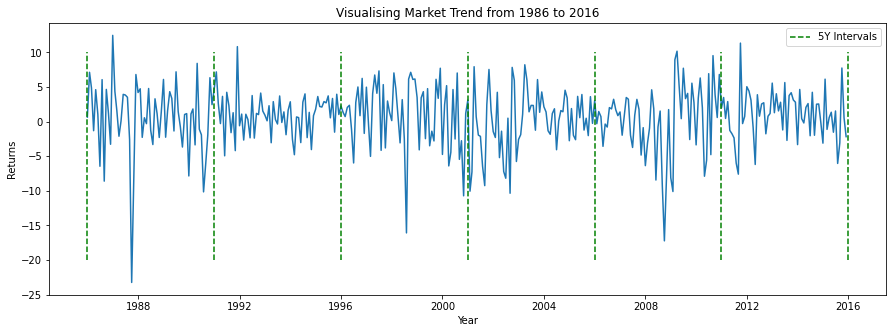

In [34]:
# Visualise market trend - No observable pattern comparing between 5Y intervals
intervals = ['1986-01-01', '1991-01-01','1996-01-01','2001-01-01','2006-01-01','2011-01-01','2016-01-01']
plt.gcf().set_size_inches(15, 5)
plt.plot(pd.to_datetime(ex_rets_with_mkt.index.astype(str), format = '%Y%m'), ex_rets_with_mkt['Mkt-RF'])
plt.vlines(x = intervals, ymin = -20, ymax = 10, colors ='g', ls = '--', label='5Y Intervals')

plt.title('Visualising Market Trend from 1986 to 2016')
plt.ylabel('Returns')
plt.legend()
plt.xlabel('Year')
plt.show()

In [35]:
# Function inputs=======================================================================

# Each sample will be in 5 year ranges, and the train set used will be for years prior.

sample=[[301, [300, 360]], # Train: Before 2010, Test: 2010-2015 (BULL)
        [241, [240, 300]]] # Train: Before 2005, Test: 2005-2010 (BEAR)


assets = ex_rets.columns.tolist()

# =======================================================================================

def backtest_metrics(ex_rets_with_mkt, sample): 

    bt_metrics = [] # each iteration will be stored in this list

    for period in sample:
        # Train_Test_Split
        train = ex_rets_with_mkt.iloc[:period[0],]
        test = ex_rets_with_mkt.iloc[period[1][0]:period[1][1],]

        # Standard Approaches (EWP, GMV, TAN, MKT)
        sample_metrics_df = obtain_mkt_values(obtain_standard_mets(obtain_standard_weights(train[assets]), test[assets]), test)       

        # Robust Approaches (Unoptimized, shrink of 0.3)
        estimates, vshrink  = estimate_return(train, estimate_beta(create_betas(train, train[assets]))), estimate_vshrink(train[assets], 0.3) 
        rb_df = robust_metrics(test[assets], robust_weights(train[assets], vshrink, estimates))
        sample_metrics_df = pd.concat([sample_metrics_df, rb_df], axis = 1)

        # Portfolio 1: Hierarchical Risk Parity
        sample_metrics_df = pd.concat([sample_metrics_df, evaluate_rpp(train[assets], test[assets])], axis =1)

        # Portfolio 2: Tan with shrinkage
        sample_metrics_df = pd.concat([sample_metrics_df,evaluate_leodoit_tan(train, test[assets], assets)], axis = 1)

        # Portfolio 3: BL 
        if period[0] == 301:
            sample_metrics_df = pd.concat([sample_metrics_df, obtain_bl_cov_matrix(train[assets], test[assets] , 'bull')], axis = 1)
        elif period[0] == 241:
            sample_metrics_df = pd.concat([sample_metrics_df, obtain_bl_cov_matrix(train[assets], test[assets] , 'bear')], axis = 1)
        bt_metrics.append(sample_metrics_df)

    return bt_metrics

backtest_list = backtest_metrics(ex_rets_with_mkt, sample)

In [36]:
# Sample backtest for Period 1, you can change the index here to view df
a = backtest_list[0]
a
# a.to_csv('bull_list.csv')

,EWP,TAN,GMV,MKT,TAN-Robust,GMV-Robust,HRP,TAN (Leodoit) - Constant Var,TAN (Leodoit) - Single Factor,TAN (Leodoit) - Constant Correl,BL,BL Market Cap
Er,0.822671,1.126216,0.861199,1.010833,1.139060,1.120130,0.711418,0.937297,0.976101,1.028226,1.241754,0.682529
sigma,3.858277,4.225915,2.964065,3.502378,2.710857,2.708045,3.818676,2.605016,2.571094,2.603760,4.509770,3.938560
var,14.886303,17.858360,8.785682,12.266648,7.348747,7.333510,14.582289,6.786106,6.610525,6.779566,20.338024,15.512257
Sharpe,0.213222,0.266502,0.290546,0.288613,0.420184,0.413630,0.186300,0.359805,0.379644,0.394900,0.275347,0.173294


In [37]:
b = backtest_list[1]
b
# b.to_csv('bear_list.csv')

,EWP,TAN,GMV,MKT,TAN-Robust,GMV-Robust,HRP,TAN (Leodoit) - Constant Var,TAN (Leodoit) - Single Factor,TAN (Leodoit) - Constant Correl,BL,BL Market Cap
Er,0.604298,0.272777,0.451122,0.206833,0.283470,0.335899,0.571819,0.466250,0.408570,0.346605,-0.175338,0.630178
sigma,5.986508,6.953761,3.841005,5.242678,4.288925,3.771845,5.818752,4.103649,3.924167,4.166965,5.387467,5.952141
var,35.838277,48.354797,14.753316,27.485673,18.394878,14.226814,33.857876,16.839935,15.399087,17.363596,29.024799,35.427987
Sharpe,0.100943,0.039227,0.117449,0.039452,0.066094,0.089054,0.098272,0.113618,0.104116,0.083179,-0.032546,0.105874


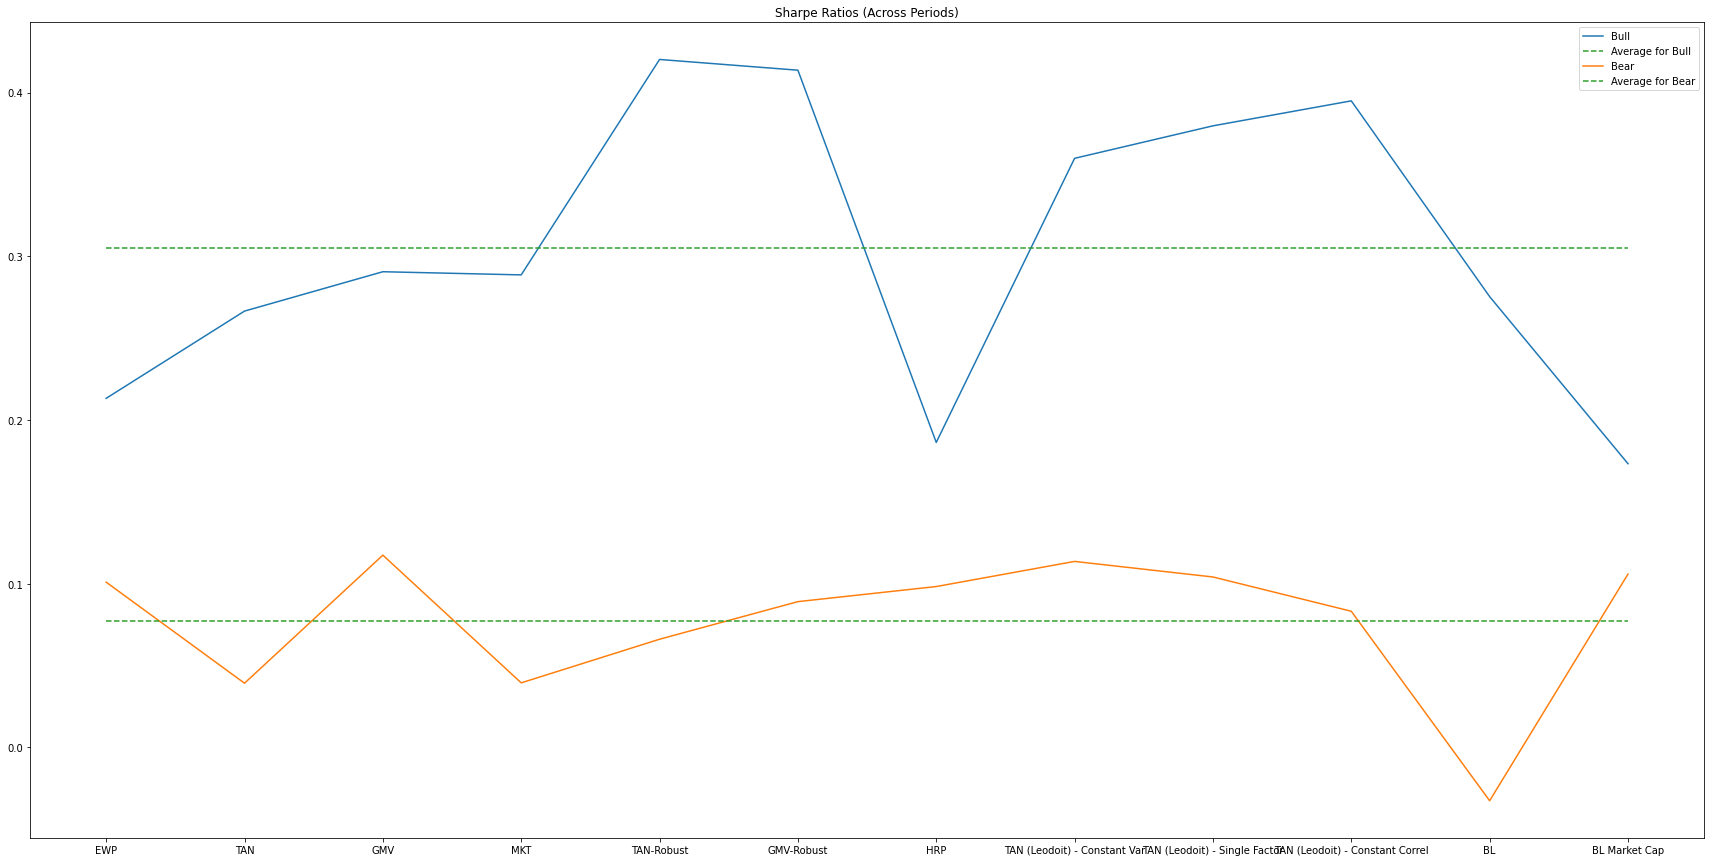

In [38]:
# Sharpe ratio comparison
periods = ['Bull', 'Bear']

for i in range(len(backtest_list)):
    x = backtest_list[i].columns.tolist()
    y = backtest_list[i].loc['Sharpe']
    ax = plt.plot(x,y, label= periods[i])
    y2 = np.mean(backtest_list[i].loc['Sharpe'])
    y2 = [y2 for i in x]
    ax2 = plt.plot(x,y2, linestyle = 'dashed' ,label= 'Average for ' + str(periods[i]), color = 'tab:green')


plt.title('Sharpe Ratios (Across Periods)')

plt.legend()
plt.gcf().set_size_inches(30,15)
plt.show()

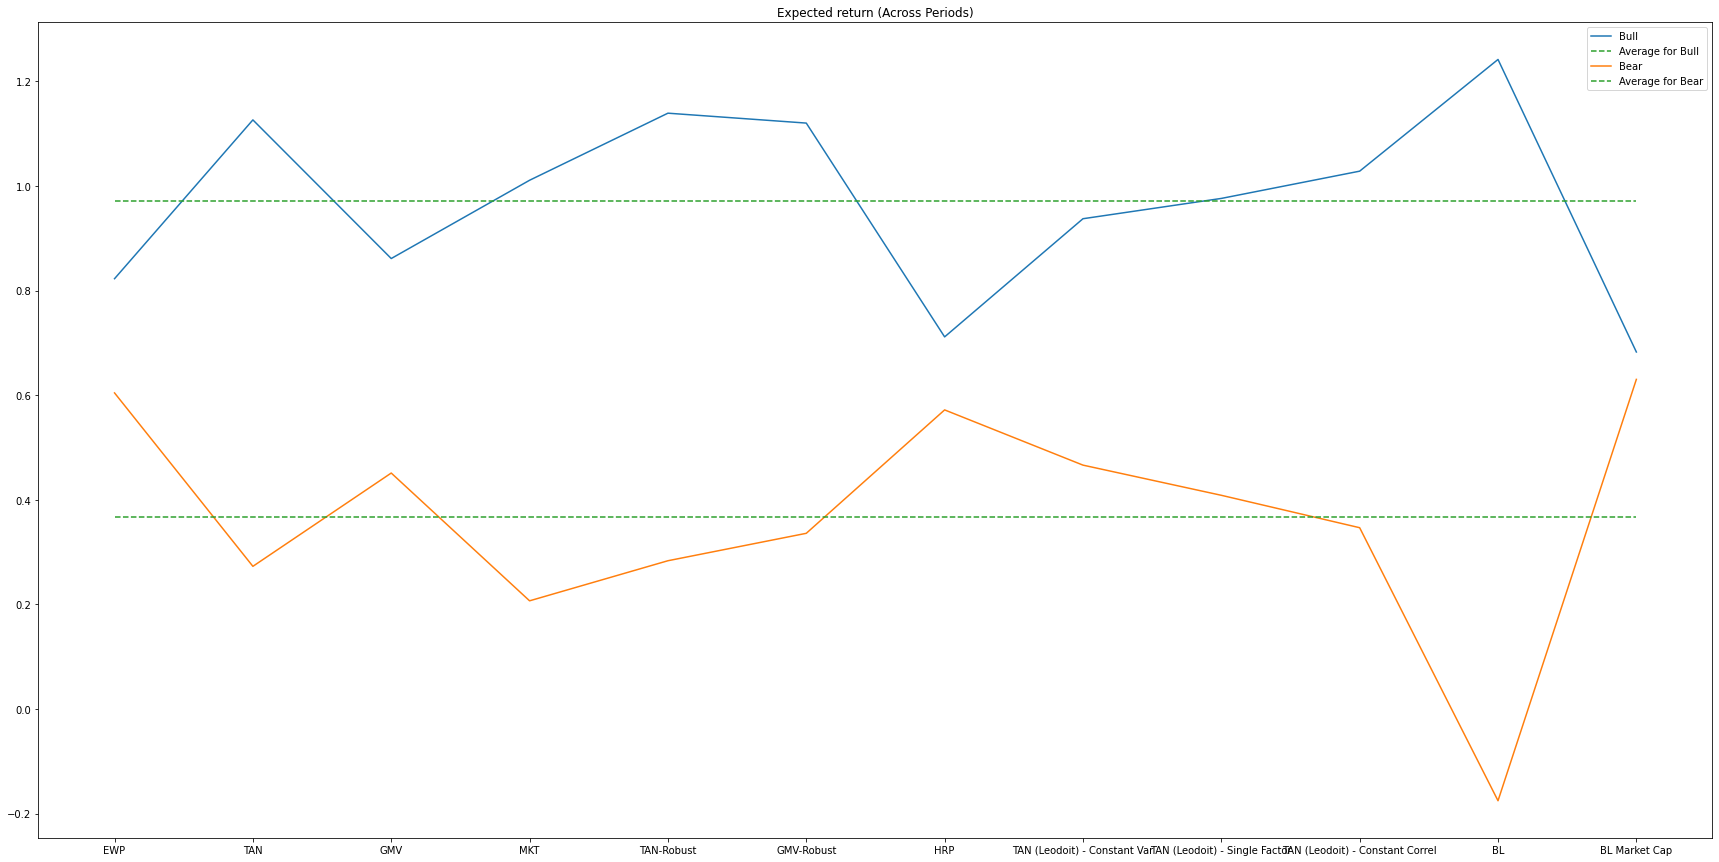

In [39]:
# Expected return comparison
periods = ['Bull', 'Bear']

for i in range(len(backtest_list)):
    x = backtest_list[i].columns.tolist()
    y = backtest_list[i].loc['Er']
    ax = plt.plot(x,y, label= periods[i])
    y2 = np.mean(backtest_list[i].loc['Er'])
    y2 = [y2 for i in x]
    ax2 = plt.plot(x,y2, linestyle = 'dashed' ,label= 'Average for ' + str(periods[i]), color = 'tab:green')


plt.title('Expected return (Across Periods)')

plt.legend()
plt.gcf().set_size_inches(30,15)
plt.show()

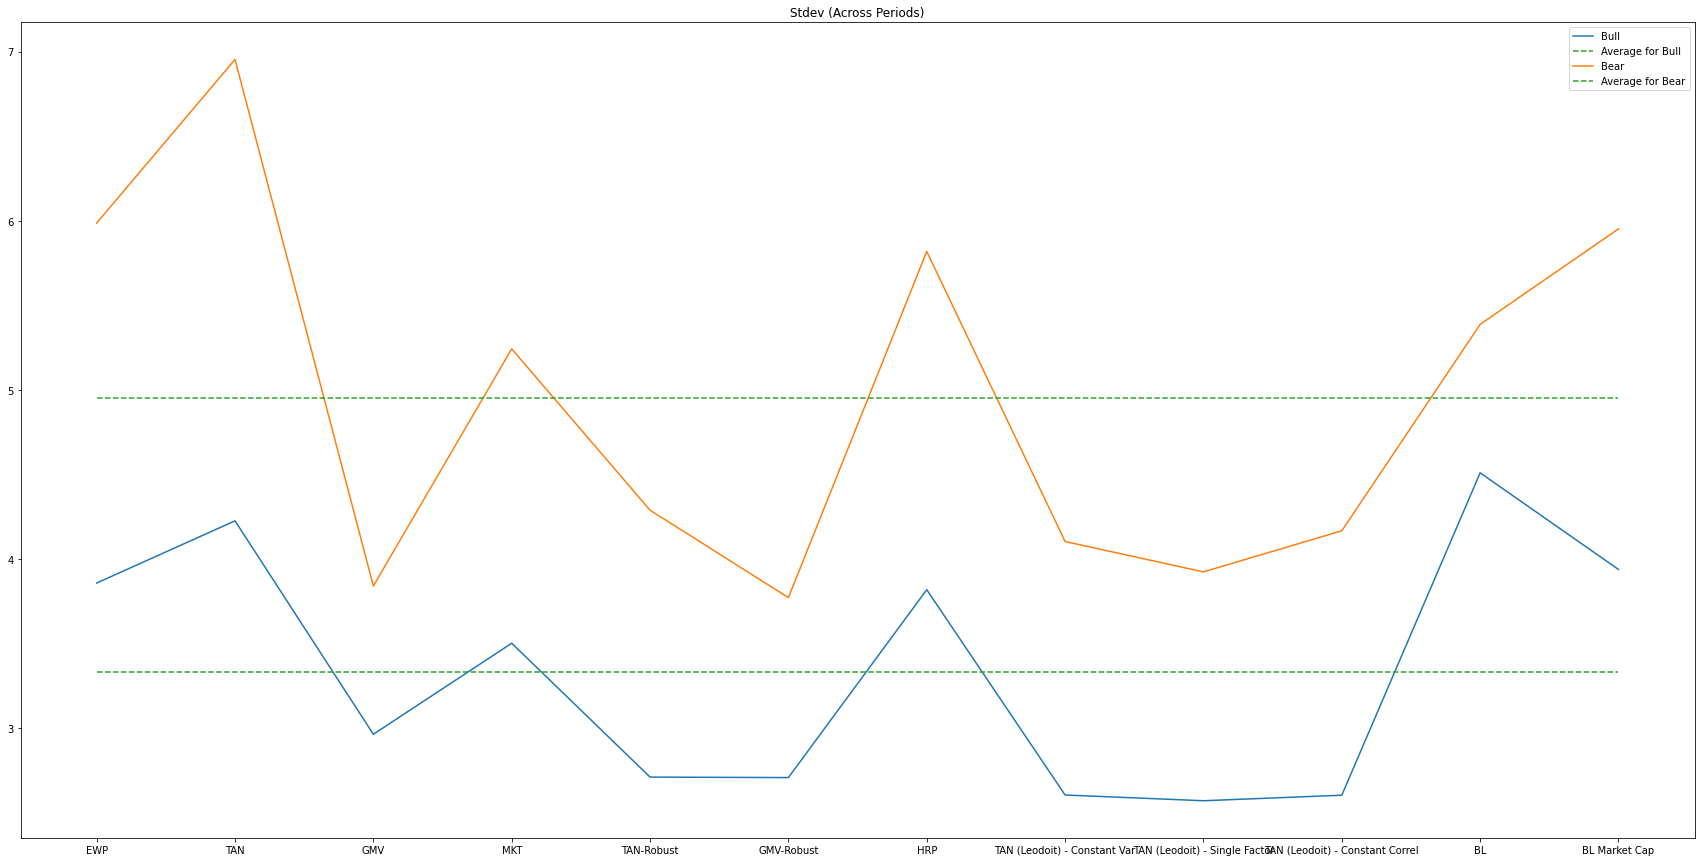

In [40]:
# Mass plot dabs
periods = ['Bull', 'Bear']

for i in range(len(backtest_list)):
    x = backtest_list[i].columns.tolist()
    y = backtest_list[i].loc['sigma']
    ax = plt.plot(x,y, label= periods[i])
    y2 = np.mean(backtest_list[i].loc['sigma'])
    y2 = [y2 for i in x]
    ax2 = plt.plot(x,y2, linestyle = 'dashed' ,label= 'Average for ' + str(periods[i]), color = 'tab:green')


plt.title('Stdev (Across Periods)')

plt.legend()
plt.gcf().set_size_inches(30,15)
plt.show()

**Create weights using entire set as test set**
-

**Chosen model: TAN with Shrunken Covariance Matrix (Constant Correlation)** 
- Expected Return: The only portfolio that maintained above average expected returns (against portfolios tested) in Bull and Bear markets
- Sharpe Ratio: One of the 4 portfolios that maintained above average sharpe ratio (against other portfolios) in Bull and Bear markets
- Volatility: Consistently below average sigma (against other portfolios) in Bull and Bear markets

In [41]:
def create_leodoit_tan_weights(train):

    ###############
    # Input:    - Train and test sets (With mkt)
    # Output:   Port metrics against test set
    ###############
    
    train_assets = train[assets]

    # Returns shrunk covariance matrix
    vshrink = (risk_models.CovarianceShrinkage(train_assets, returns_data= True, frequency=12).ledoit_wolf(shrinkage_target= 'single_factor'))

    # Returns capm defined expected returns for tangency
    mucapm = estimate_return(train, estimate_beta(create_betas(train, train_assets)))

    # Obtain inputs for Portfolio Weights function
    weight_inputs, basic_port = [[mucapm['Mu CAPM'], vshrink]], ['tan']

    # Create lists of weights using function
    weight = [portfolio_weights(weight_inputs[i], basic_port[i]) for i in range(len(basic_port))]

    weights_df = pd.DataFrame()
    weights_df['Weights'] = weight[0]
    weights_df = weights_df.set_axis(assets, axis =0)

    return weights_df

final_weights = create_leodoit_tan_weights(ex_rets_with_mkt)
print(final_weights.Weights.sum())


1.0000000000000002


In [42]:
final_weights_exp = final_weights.copy()
final_weights_exp = final_weights_exp.set_axis(['G2.5'], axis =1)
final_weights_exp.to_csv('Recommendations_G2.csv', index = False)


In [43]:
final_weights = final_weights.sort_values(by = 'Weights')

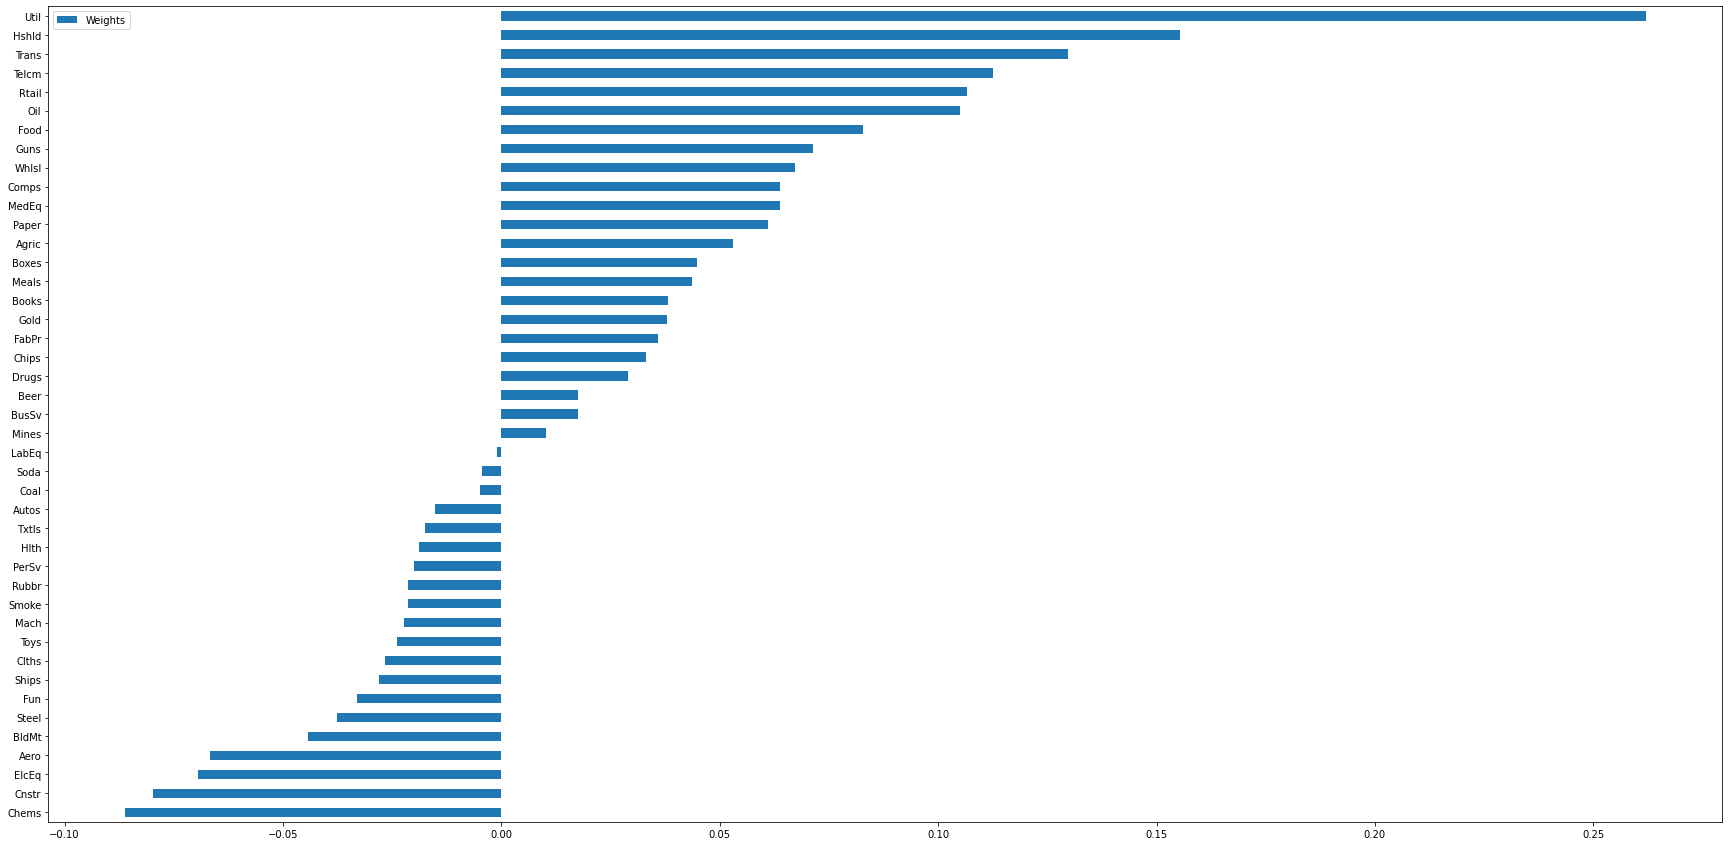

In [44]:
final_weights.plot.barh()
plt.gcf().set_size_inches(30,15)
plt.show()

In [45]:
portfolio_metrics(final_weights['Weights'], ex_rets)

{'Er': 0.6322181499817399,
 'sigma': 5.171827464045476,
 'var': 26.747799317855065,
 'Sharpe': 0.12224269938951327}

# Last updated 16 Nov 2022, peace :)